
# 4.1.X — Modèles de diffusion & **sauts** (Brownien, GBM, OU, Merton)

## 🎯 Objectifs
- Comprendre et **simuler** plusieurs modèles de diffusion : **Brownien avec drift**, **GBM**, **Ornstein–Uhlenbeck**.
- Introduire un **modèle à sauts** (Merton jump-diffusion) et l’implémenter.
- Comparer **moyennes estimées Monte Carlo** aux **moyennes théoriques** (dérivées **en Markdown**).
- Visualiser par des **graphes** les trajectoires et les distributions finales.



## 1) Panorama rapide des modèles

| Modèle | EDS | Solution / Propriété | Espérance $\mathbb{E}[X_t]$ |
|---|---|---|---|
| Brownien arithmétique | $dX_t = \mu\,dt + \sigma\,dW_t$ | $X_t = X_0 + \mu t + \sigma W_t$ | $X_0 + \mu t$ |
| GBM (prix positif) | $dS_t = \mu S_t dt + \sigma S_t dW_t$ | $S_t = S_0\,\exp((\mu-\tfrac12\sigma^2)t + \sigma W_t)$ | $S_0 e^{\mu t}$ |
| OU / Vasicek | $dr_t = k(\theta - r_t)dt + \sigma dW_t$ | Mean-reverting | $\theta + (r_0-\theta)e^{-k t}$ |
| Merton jump-diffusion | $\tfrac{dS_t}{S_t} = (\mu - \lambda \kappa) dt + \sigma dW_t + dJ_t$ | Sauts Poisson + tailles lognormales | $S_0 e^{\mu t}$ (si drift compensé) |

où $\kappa = \mathbb{E}[Y-1]$ avec $Y$ la **taille de saut multiplicative** et $N_t \sim \mathrm{Poisson}(\lambda t)$.



## 2) Brownien arithmétique (drift + diffusion)

**EDS** : $dX_t = \mu\,dt + \sigma\,dW_t$.  
**Solution** : $X_t = X_0 + \mu t + \sigma W_t$.  
**Espérance** : $\mathbb{E}[X_t] = X_0 + \mu t$ (car $\mathbb{E}[W_t]=0$).

Nous allons simuler des trajectoires et comparer la moyenne Monte Carlo à la formule.


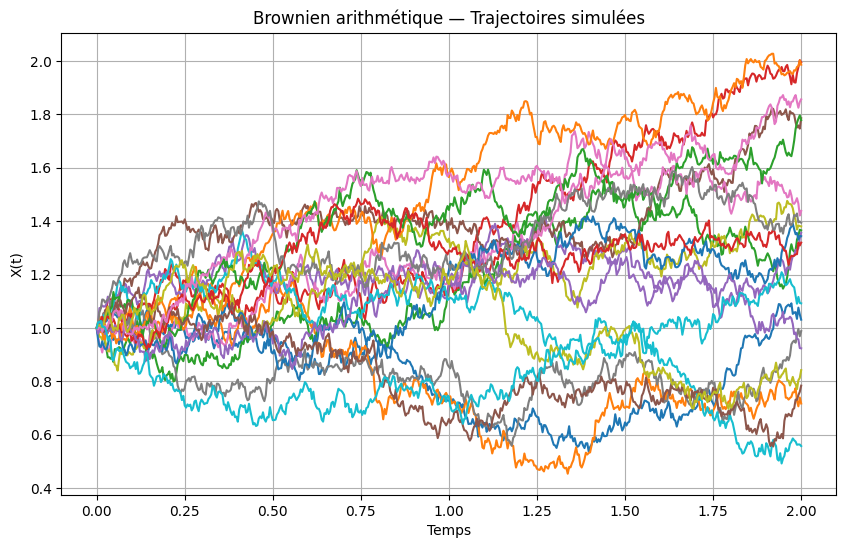

(np.float64(1.402905244779151), 1.4)

In [1]:

import numpy as np
import matplotlib.pyplot as plt

def simulate_brownian_arithmetic(X0=0.0, mu=0.1, sigma=0.2, T=1.0, N=252, n_paths=20, seed=0):
    rng = np.random.default_rng(seed)
    dt = T/N
    dW = rng.normal(0.0, np.sqrt(dt), size=(n_paths, N))
    X = np.full((n_paths, N+1), X0, dtype=float)
    for i in range(N):
        X[:, i+1] = X[:, i] + mu*dt + sigma*dW[:, i]
    t = np.linspace(0, T, N+1)
    return t, X

t, X = simulate_brownian_arithmetic(X0=1.0, mu=0.2, sigma=0.3, T=2.0, N=504, n_paths=20, seed=1)
plt.figure(figsize=(10,6))
for k in range(X.shape[0]):
    plt.plot(t, X[k])
plt.title("Brownien arithmétique — Trajectoires simulées")
plt.xlabel("Temps"); plt.ylabel("X(t)"); plt.grid(True); plt.show()

def mc_mean_brownian_arithmetic(X0=1.0, mu=0.2, sigma=0.3, T=2.0, N=504, M=20000, seed=2):
    rng = np.random.default_rng(seed)
    dt = T/N
    dW = rng.normal(0.0, np.sqrt(dt), size=(M, N))
    X = np.full((M, N+1), X0, dtype=float)
    for i in range(N):
        X[:, i+1] = X[:, i] + mu*dt + sigma*dW[:, i]
    return X[:, -1].mean()

M_mean = mc_mean_brownian_arithmetic()
theo = 1.0 + 0.2*2.0
M_mean, theo



## 3) GBM (mouvement brownien géométrique)

**EDS** : $dS_t = \mu S_t dt + \sigma S_t dW_t$.  
**Solution** : $S_t = S_0\,\exp((\mu-\tfrac12\sigma^2)t + \sigma W_t)$.  
**Espérance** : $\mathbb{E}[S_t] = S_0 e^{\mu t}$.

On simule via **Euler–Maruyama** (ou trajectoire exacte en log) et on compare $\mathbb{E}[S_T]$.


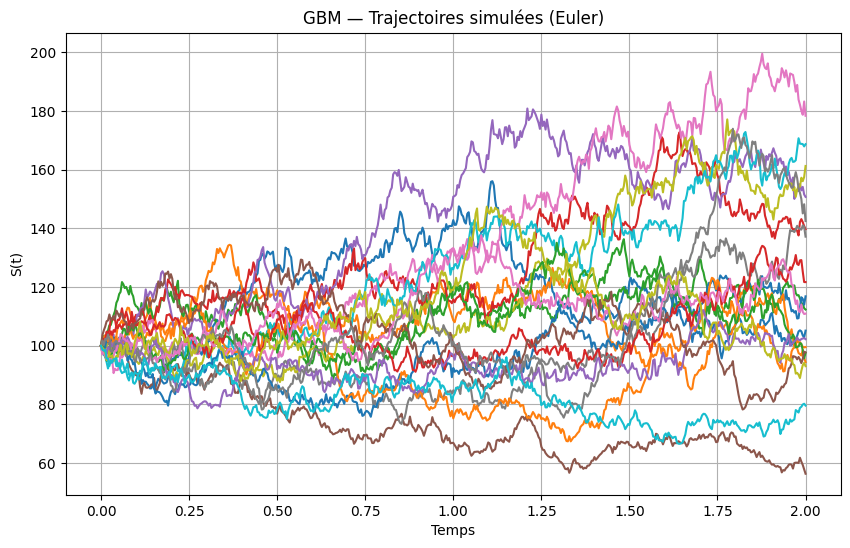

(np.float64(107.94603794697372), np.float64(108.32870676749586))

In [2]:

def simulate_gbm(S0=100.0, mu=0.05, sigma=0.2, T=1.0, N=252, n_paths=20, seed=3):
    rng = np.random.default_rng(seed)
    dt = T/N
    S = np.full((n_paths, N+1), S0, dtype=float)
    for i in range(N):
        z = rng.standard_normal(n_paths)
        S[:, i+1] = S[:, i] * (1 + mu*dt + sigma*np.sqrt(dt)*z)
    t = np.linspace(0, T, N+1)
    return t, S

t, S = simulate_gbm(S0=100, mu=0.04, sigma=0.25, T=2.0, N=504, n_paths=20, seed=4)
plt.figure(figsize=(10,6))
for k in range(S.shape[0]):
    plt.plot(t, S[k])
plt.title("GBM — Trajectoires simulées (Euler)")
plt.xlabel("Temps"); plt.ylabel("S(t)"); plt.grid(True); plt.show()

def mc_mean_gbm(S0=100, mu=0.04, sigma=0.25, T=2.0, N=504, M=20000, seed=5):
    rng = np.random.default_rng(seed)
    dt = T/N
    S = np.full((M, N+1), S0, dtype=float)
    for i in range(N):
        z = rng.standard_normal(M)
        S[:, i+1] = S[:, i] * (1 + mu*dt + sigma*np.sqrt(dt)*z)
    return S[:, -1].mean()

M_mean = mc_mean_gbm()
theo = 100*np.exp(0.04*2.0)
M_mean, theo



## 4) Ornstein–Uhlenbeck (OU) / Vasicek (taux mean-reverting)

**EDS** : $dr_t = k(\theta - r_t)dt + \sigma dW_t$, avec $k>0$.  
**Espérance** : $\mathbb{E}[r_t] = \theta + (r_0-\theta)e^{-k t}$.

On simule avec la **discrétisation exacte** et on compare la moyenne MC à la formule.


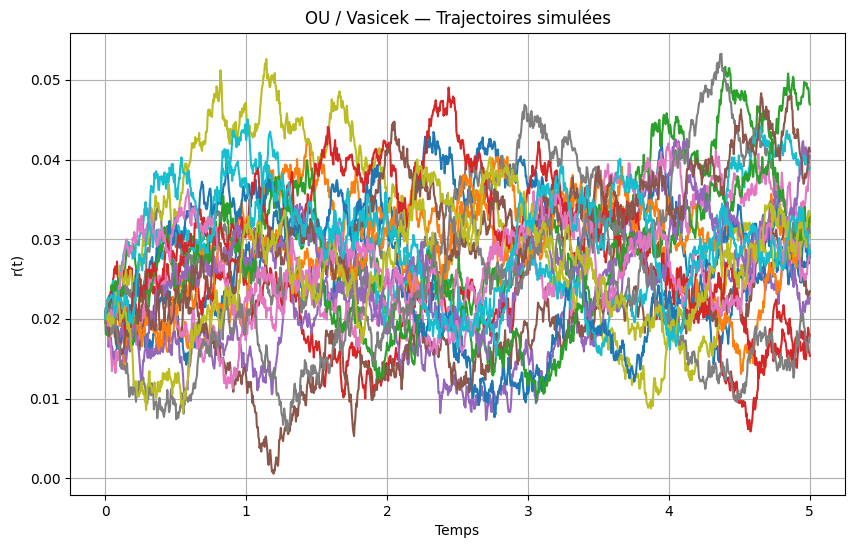

(np.float64(0.029498381064166357), np.float64(0.029698026165776815))

In [3]:

def simulate_ou_exact(r0=0.02, k=0.7, theta=0.03, sigma=0.012, T=5.0, N=252*5, n_paths=20, seed=6):
    rng = np.random.default_rng(seed)
    dt = T/N
    r = np.full((n_paths, N+1), r0, dtype=float)
    a = np.exp(-k*dt)
    sd = sigma * np.sqrt((1 - np.exp(-2*k*dt)) / (2*k))
    for i in range(N):
        z = rng.standard_normal(n_paths)
        r[:, i+1] = theta + (r[:, i]-theta)*a + sd*z
    t = np.linspace(0, T, N+1)
    return t, r

t, r = simulate_ou_exact()
plt.figure(figsize=(10,6))
for k_ in range(r.shape[0]):
    plt.plot(t, r[k_])
plt.title("OU / Vasicek — Trajectoires simulées")
plt.xlabel("Temps"); plt.ylabel("r(t)"); plt.grid(True); plt.show()

def mc_mean_ou(r0=0.02, k=0.7, theta=0.03, sigma=0.012, T=5.0, N=252*5, M=20000, seed=7):
    rng = np.random.default_rng(seed)
    dt = T/N
    a = np.exp(-k*dt)
    sd = sigma * np.sqrt((1 - np.exp(-2*k*dt)) / (2*k))
    r = np.full((M, N+1), r0, dtype=float)
    for i in range(N):
        z = rng.standard_normal(M)
        r[:, i+1] = theta + (r[:, i]-theta)*a + sd*z
    return r[:, -1].mean()

M_mean = mc_mean_ou()
theo = 0.03 + (0.02-0.03)*np.exp(-0.7*5.0)
M_mean, theo



## 5) Modèle **Merton Jump–Diffusion** (sauts lognormaux)

**Dynamique (drift compensé)** :
$$
\frac{dS_t}{S_t} = (\mu - \lambda \kappa)\,dt + \sigma\,dW_t + dJ_t,
$$
où $N_t\sim \mathrm{Poisson}(\lambda t)$, les sauts multiplicatifs sont $Y_i$ i.i.d., et  
$J_t = \sum_{i=1}^{N_t} (Y_i - 1)$, $\kappa = \mathbb{E}[Y-1]$.  
Avec ce **drift compensé**, on a $\mathbb{E}[S_t] = S_0 e^{\mu t}$.

**Choix classique pour $Y$** : $\ln Y \sim \mathcal{N}(m_J, s_J^2)$ $\Rightarrow \kappa = e^{m_J + \tfrac12 s_J^2} - 1$.


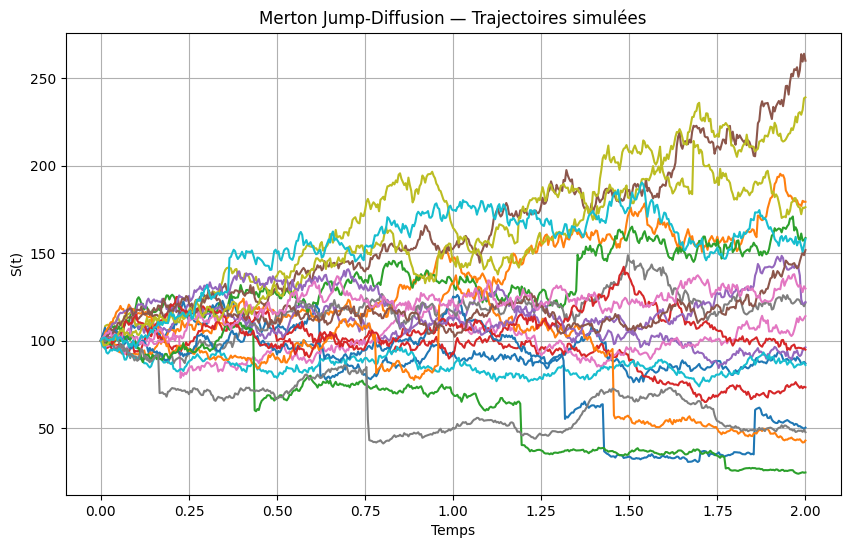

(np.float64(107.65086884627584), np.float64(108.32870676749586))

In [4]:

def simulate_merton_jump_diffusion(S0=100.0, mu=0.05, sigma=0.2, 
                                   lam=0.5, mJ=-0.1, sJ=0.3, 
                                   T=2.0, N=504, n_paths=20, seed=10):
    rng = np.random.default_rng(seed)
    dt = T/N
    kappa = np.exp(mJ + 0.5*sJ**2) - 1.0
    mu_eff = mu - lam*kappa

    S = np.full((n_paths, N+1), S0, dtype=float)
    for i in range(N):
        z = rng.standard_normal(n_paths)
        S[:, i+1] = S[:, i] * (1 + mu_eff*dt + sigma*np.sqrt(dt)*z)
        Nj = rng.poisson(lam*dt, size=n_paths)
        if Nj.any():
            idx = np.where(Nj>0)[0]
            if len(idx)>0:
                # sum of log Y ~ Normal(Nj*mJ, Nj*sJ^2)
                logY = rng.normal(mJ*Nj[idx], sJ*np.sqrt(Nj[idx]))
                S[idx, i+1] *= np.exp(logY)
    t = np.linspace(0, T, N+1)
    return t, S

t, SJ = simulate_merton_jump_diffusion(S0=100, mu=0.04, sigma=0.25, lam=0.8, mJ=-0.1, sJ=0.3, 
                                       T=2.0, N=504, n_paths=20, seed=11)
plt.figure(figsize=(10,6))
for k_ in range(SJ.shape[0]):
    plt.plot(t, SJ[k_])
plt.title("Merton Jump-Diffusion — Trajectoires simulées")
plt.xlabel("Temps"); plt.ylabel("S(t)"); plt.grid(True); plt.show()

def mc_mean_merton(S0=100, mu=0.04, sigma=0.25, lam=0.8, mJ=-0.1, sJ=0.3, 
                   T=2.0, N=504, M=20000, seed=12):
    rng = np.random.default_rng(seed)
    dt = T/N
    kappa = np.exp(mJ + 0.5*sJ**2) - 1.0
    mu_eff = mu - lam*kappa
    S = np.full((M, N+1), S0, dtype=float)
    for i in range(N):
        z = rng.standard_normal(M)
        S[:, i+1] = S[:, i] * (1 + mu_eff*dt + sigma*np.sqrt(dt)*z)
        Nj = rng.poisson(lam*dt, size=M)
        if Nj.any():
            idx = np.where(Nj>0)[0]
            if len(idx)>0:
                logY = rng.normal(mJ*Nj[idx], sJ*np.sqrt(Nj[idx]))
                S[idx, i+1] *= np.exp(logY)
    return S[:, -1].mean()

M_mean = mc_mean_merton()
theo = 100*np.exp(0.04*2.0)
M_mean, theo



---

## 6) Synthèse & comparaison des moyennes (Markdown)

- **Brownien arithmétique** :  
  $$\mathbb{E}[X_T] = X_0 + \mu T,$$
  car $\mathbb{E}[W_T]=0$.

- **GBM** :  
  $$\mathbb{E}[S_T] = S_0 e^{\mu T}.$$
  En effet, $\ln S_T = \ln S_0 + (\mu-\tfrac12\sigma^2)T + \sigma W_T$,  
  donc $\mathbb{E}[S_T] = S_0 \exp((\mu-\tfrac12\sigma^2)T)\, \mathbb{E}[\exp(\sigma W_T)] = S_0 e^{\mu T}$,  
  puisque $\mathbb{E}[e^{\sigma W_T}] = e^{\tfrac12 \sigma^2 T}$.

- **OU** :  
  $$\mathbb{E}[r_T] = \theta + (r_0 - \theta)\,e^{-kT}.$$
  On résout l’EDS linéaire par facteur intégrant (ou en utilisant la solution exacte).

- **Merton (drift compensé)** :  
  $$\frac{dS_t}{S_t} = (\mu - \lambda \kappa)dt + \sigma dW_t + dJ_t,$$
  avec $\kappa = \mathbb{E}[Y-1]$.  
  On obtient $\mathbb{E}[S_T] = S_0 e^{\mu T}$, la compensation retirant l’effet moyen des sauts.

> En pratique, commencer par **vérifier les moyennes MC** vs théorie pour valider vos schémas avant d’utiliser ces simulateurs dans des pricers plus complexes.



## ✍️ Exercices essentiels
1. **GBM exact** : implémentez la mise à jour exacte en log et comparez la moyenne MC à Euler pour $N=64, 256, 1024$.  
2. **OU moyenne en temps** : calculez $\overline{r}(t)$ (moyenne empirique au temps $t$) et superposez la courbe théorique pour plusieurs $k$.  
3. **Merton $\kappa$** : simulez $10^6$ tailles de saut $Y$ (lognormales) et estimez $\mathbb{E}[Y-1]$. Comparez à $e^{m_J + 0.5 s_J^2}-1$.  
4. (**Bonus**) Tracez les **histogrammes** de $S_T$ pour GBM vs Merton et commentez l'effet des sauts sur la **queue** de distribution.
